In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from torch import cuda
from timeit import default_timer as timer
from torchsummary import summary
import pandas as pd

In [ ]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  "/content/drive/MyDrive/315_Birds_Species.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/VARIED THRUSH/029.jpg  
  inflating: train/VARIED THRUSH/030.jpg  
  inflating: train/VARIED THRUSH/031.jpg  
  inflating: train/VARIED THRUSH/032.jpg  
  inflating: train/VARIED THRUSH/033.jpg  
  inflating: train/VARIED THRUSH/034.jpg  
  inflating: train/VARIED THRUSH/035.jpg  
  inflating: train/VARIED THRUSH/036.jpg  
  inflating: train/VARIED THRUSH/037.jpg  
  inflating: train/VARIED THRUSH/038.jpg  
  inflating: train/VARIED THRUSH/039.jpg  
  inflating: train/VARIED THRUSH/040.jpg  
  inflating: train/VARIED THRUSH/041.jpg  
  inflating: train/VARIED THRUSH/042.jpg  
  inflating: train/VARIED THRUSH/043.jpg  
  inflating: train/VARIED THRUSH/044.jpg  
  inflating: train/VARIED THRUSH/045.jpg  
  inflating: train/VARIED THRUSH/046.jpg  
  inflating: train/VARIED THRUSH/047.jpg  
  inflating: train/VARIED THRUSH/048.jpg  
  inflating: train/VARIED THRUSH/049.jpg  
  inflating: train/VARIED THRUSH/050.jpg  
  i

In [ ]:
TRAIN_DIR = '/content/train'
VALID_DIR = '/content/valid'
TEST_DIR = '/content/test'

WEIGHT_PATH = '/content/315_Birds_Species/'
SAVE_IMAGE_PATH = '/content/315_Birds_Species/'

SAVE_TEST_RESULTS_PATH = '/content/'

device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')

In [ ]:
BATCH_SIZE = 128
N_EPOCHS = 20
LR = 0.0005
N_GPU = 1
SET_L = False
INPUT_D = 3 if SET_L == False else 1

In [ ]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=TRAIN_DIR, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=VALID_DIR, transform=image_transforms['valid']),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['valid'], batch_size=BATCH_SIZE, shuffle=True)
}


In [ ]:
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

viter = iter(dataloaders['val'])
features, labels = next(viter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [ ]:
model = models.vgg16(pretrained=True)

In [ ]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(5232, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 2),
                      nn.LogSoftmax(dim=1))


In [ ]:
# Only training classifier[6]
model.classifier


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=5232, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,600,706 total parameters.
1,340,162 training parameters.


In [ ]:

# Whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
# Move to gpu
#model = model.to('cuda')
# Distribute across 2 gpus
#model = nn.DataParallel(model)

Train on gpu: True
1 gpus detected.


In [ ]:
# Loss and optimizer
criteration = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
n_classes = 315
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

#    elif model_name == 'resnet50':
#        model = models.resnet50(pretrained=True)

#        for param in model.parameters():
#            param.requires_grad = False

#        n_inputs = model.fc.in_features
#        model.fc = nn.Sequential(
#            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
#            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

#    if multi_gpu:
#        model = nn.DataParallel(model)

    return model


In [ ]:
# Whether to train on a gpu

train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
n_classes = 315
model = get_pretrained_model('vgg16')
#if multi_gpu:
#    summary(
#        model.module,
#        input_size=(3, 224, 224),
#        batch_size=BATCH_SIZE,
#        device='cuda')

summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cuda')

Train on gpu: True
1 gpus detected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
   

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history



In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
save_file_name = 'vgg16-transfer-4.pt'
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=20,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.2605 	Validation Loss: 0.6725
		Training Accuracy: 47.00%	 Validation Accuracy: 81.59%

Epoch: 1 	Training Loss: 1.2860 	Validation Loss: 0.5192
		Training Accuracy: 65.33%	 Validation Accuracy: 84.63%

Epoch: 2 	Training Loss: 1.1456 	Validation Loss: 0.4565
		Training Accuracy: 68.63%	 Validation Accuracy: 86.92%

Epoch: 3 	Training Loss: 1.0821 	Validation Loss: 0.4117
		Training Accuracy: 69.81%	 Validation Accuracy: 88.76%

Epoch: 4 	Training Loss: 1.0336 	Validation Loss: 0.3936
		Training Accuracy: 71.04%	 Validation Accuracy: 88.70%

Epoch: 5 	Training Loss: 1.0075 	Validation Loss: 0.3857
		Training Accuracy: 71.79%	 Validation Accuracy: 88.57%

Epoch: 6 	Training Loss: 0.9949 	Validation Loss: 0.3841
		Training Accuracy: 72.27%	 Validation Accuracy: 88.70%

Epoch: 7 	Training Loss: 0.9693 	Validation Loss: 0.3524
		Training Accuracy: 73.08%	 Validation Accuracy: 89.78%

Epoch: 8 	Training Loss: 0.9661 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

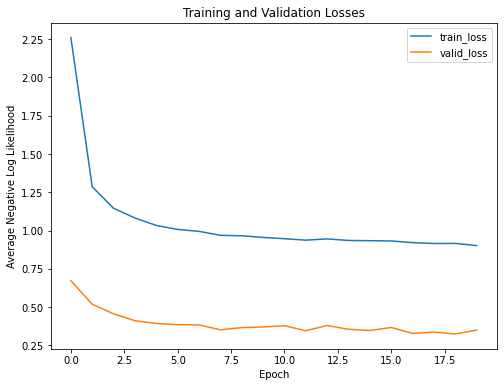

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

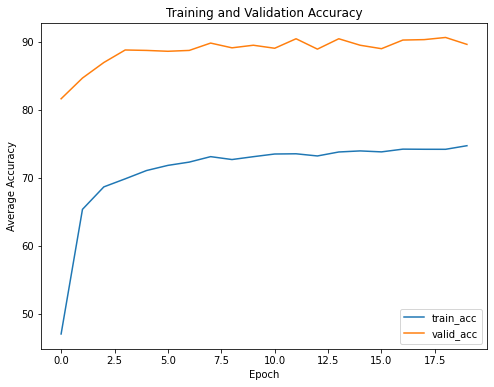

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
